The following notebook was developed using the following references:
* [Build your own Transformer from scratch using Pytorch](https://towardsdatascience.com/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb)
* [Tutorial 6: Transformers and Multi-Head Attention](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html)

In [1]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
from torch import nn, optim
from torch.utils import data
import copy

In [2]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## What is Attention?
The attention mechanism describes a recent new group of layers in neural networks that has attracted a lot of interest in the past few years, especially in sequence tasks. There are a lot of different possible definitions of “attention” in the literature, but the one we will use here is the following: the attention mechanism describes a weighted average of (sequence) elements with the weights dynamically computed based on an input query and elements’ keys. So what does this exactly mean? The goal is to take an average over the features of multiple elements. However, instead of weighting each element equally, we want to weight them depending on their actual values. In other words, we want to dynamically decide on which inputs we want to “attend” more than others. In particular, an attention mechanism has usually four parts we need to specify:

* **Query:** The query is a feature vector that describes what we are looking for in the sequence, i.e. what would we maybe want to pay attention to.
* **Keys:** For each input element, we have a key which is again a feature vector. This feature vector roughly describes what the element is “offering”, or when it might be important. The keys should be designed such that we can identify the elements we want to pay attention to based on the query.
* **Values:** For each input element, we also have a value vector. This feature vector is the one we want to average over.
* **Score function:** To rate which elements we want to pay attention to, we need to specify a score function $f_{attn}$. The score function takes the query and a key as input, and output the score/attention weight of the query-key pair. It is usually implemented by simple similarity metrics like a dot product, or a small MLP.

The weights of the average are calculated by a softmax over all score function outputs. Hence, we assign those value vectors a higher weight whose corresponding key is most similar to the query. If we try to describe it with pseudo-math, we can write:
\begin{equation}
a_i=\frac{exp(f_{attn}(key_i ,query))}{\sum_j exp(f_{attn}(key_j ,query))},   out = \sum_i{a_i \cdot value}
\end{equation}
Visually, we can show the attention over a sequence of words as follows:

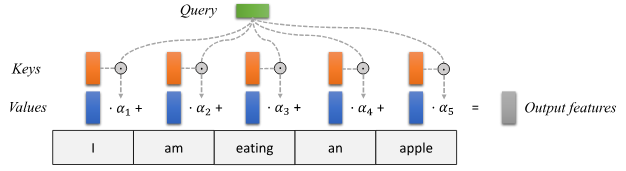

For every word, we have one key and one value vector. The query is compared to all keys with a score function (in this case the dot product) to determine the weights. The softmax is not visualized for simplicity. Finally, the value vectors of all words are averaged using the attention weights.

Most attention mechanisms differ in terms of what queries they use, how the key and value vectors are defined, and what score function is used. The attention applied inside the Transformer architecture is called self-attention. In self-attention, each sequence element provides a key, value, and query. For each element, we perform an attention layer where based on its query, we check the similarity of the all sequence elements’ keys, and returned a different, averaged value vector for each element. We will now go into a bit more detail by first looking at the specific implementation of the attention mechanism which is in the Transformer case the scaled dot product attention.

## Scaled Dot Product Attention
The core concept behind self-attention is the scaled dot product attention. Our goal is to have an attention mechanism with which any element in a sequence can attend to any other while still being efficient to compute. The dot product attention takes as input a set of queries $Q \in \mathbb{R}^{T \times d_k}$, keys $K \in \mathbb{R}^{T \times d_k}$ and values $V \in \mathbb{R}^{T \times d_v}$  where $T$ is the sequence length, and $d_k$ and $d_v$ are the hidden dimensionality for queries/keys and values respectively. For simplicity, we neglect the batch dimension for now. The attention value from element $i$ to $j$ is based on its similarity of the query $Q_i$ and key $K_j$, using the dot product as the similarity metric. In math, we calculate the dot product attention as follows:
\begin{equation}
Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V
\end{equation}
The matrix multiplication $QK^T$ performs the dot product for every possible pair of queries and keys, resulting in a matrix of the shape $T \times T$. Each row represents the attention logits for a specific element $i$ to all other elements in the sequence. On these, we apply a softmax and multiply with the value vector to obtain a weighted mean (the weights being determined by the attention). Another perspective on this attention mechanism offers the computation graph which is visualized below (figure credit - Vaswani et al., 2017).

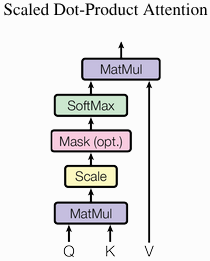

One aspect we haven’t discussed yet is the scaling factor of $1/\sqrt{d_k}$. This scaling factor is crucial to maintain an appropriate variance of attention values after initialisation. Remember that we intialize our layers with the intention of having equal variance throughout the model, and hence, $Q$ and $K$ might also have a variance close to $1$. However, performing a dot product over two vectors with a variance $\sigma^2$ results in a scalar having $d_k$-times higher variance:
\begin{equation}
q_i~N(0,\sigma^2),k_i~N(0,\sigma^2) \to Var(\sum^{d_k}_{i=1} q_i \cdot k_i)=\sigma^4 \cdot d_k
\end{equation}
If we do not scale down the variance back to $~\sigma^2$, , the softmax over the logits will already saturate to $1$ for one random element and $0$ for all others. The gradients through the softmax will be close to zero so that we can’t learn the parameters appropriately. Note that the extra factor of $\sigma^2$, i.e. having $\sigma^4$ instead of $\sigma^2$, is usually not an issue, since we keep the original variance $\sigma^2$ close to $1$ anyways.

The block Mask (opt.) in the diagram above represents the optional masking of specific entries in the attention matrix. This is for instance used if we stack multiple sequences with different lengths into a batch. To still benefit from parallelization in PyTorch, we pad the sentences to the same length and mask out the padding tokens during the calculation of the attention values. This is usually done by setting the respective attention logits to a very low value.

After we have discussed the details of the scaled dot product attention block, we can write a function below which computes the output features given the triple of queries, keys, and values:

## Multi-head attention
The Multi-Head Attention mechanism computes the attention between each pair of positions in a sequence. It consists of multiple “attention heads” that capture different aspects of the input sequence.
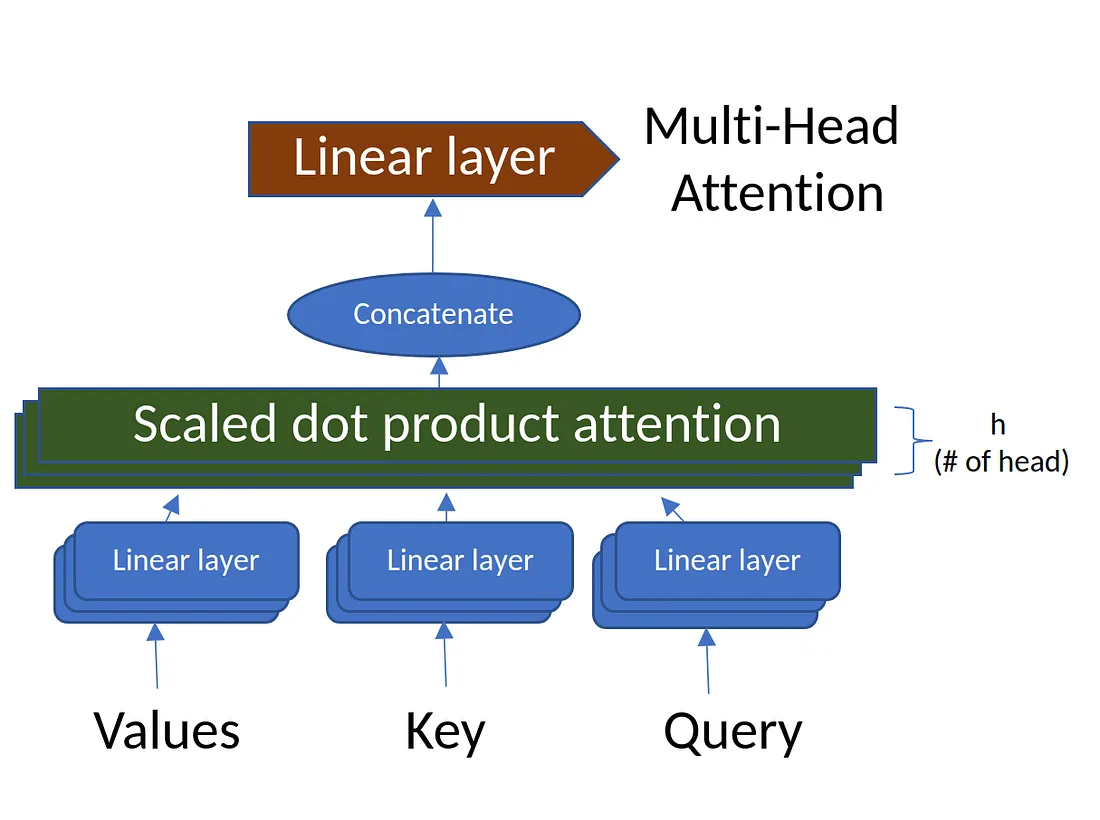
<br>The MultiHeadAttention code initializes the module with input parameters and linear transformation layers. It calculates attention scores, reshapes the input tensor into multiple heads, and combines the attention outputs from all heads. The forward method computes the multi-head self-attention, allowing the model to focus on some different aspects of the input sequence.

scaled_dot_product() follows a similar design to the efficient pytorch implementation


The following was adapted from [torch.nn.functional.scaled_dot_product_attention](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html)

In [49]:
# Efficient implementation equivalent to the following:
def scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=0.0) -> torch.Tensor:
    """
    Combine three tensors; query, key, and value; to generate an output tensor of scaled dot product attention.

    Parameters:
    - query (Tensor)              - shape (N x ... x L x E)
    - key (Tensor)                - shape (N x ... x S x E)
    - value (Tensor)              - shape (N x ... x S x Ev)
    - attn_mask (optional Tensor) - shape (N x ... x L x S)

            Attention mask; shape must be broadcastable to the shape of attention weights.
                            Two types of masks are supported. 
                                1) A boolean mask where a value of True indicates that the element should take part in attention. 
                                2) A float mask of the same type as query, key, value that is added to the attention score.

    - dropout_p (float)           - Dropout probability; if greater than 0.0, dropout is applied

    Returns:
    - Attention output (Tensor)   - shape (N x ... x L x Ev)


    Shape legend:
    - N:    Batch size
    - ...:  Any number of other batch dimensions (optional)
    - S:    Source sequence length
    - L:    Target sequence length
    - E:    Embedding dimension of the query and key
    - Ev:   Embedding dimension of the value
    """
    L, S = query.size(-2), key.size(-2)

    # Calculate scaling factor ahead of time
    scale_factor = 1 / math.sqrt(query.size(-1))

    # Pre-define attn_bias as zero-weighted tensor
    # this allows it to be included in the attn_weight 
    # calculation regardless of being defined
    attn_bias = torch.zeros(L, S, dtype=query.dtype)

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
        else:
            attn_bias += attn_mask

    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    attn_weight = torch.softmax(attn_weight, dim=-1)
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
    return value, attn_weight
    #return attn_weight @ value

### Testing scaled_dot_product() components

In [63]:
# Define a tensor representing a vector of key weights that are "word sequence length" X "number of keys"
torch.manual_seed(42)
N = 7 #
S = 3 # Source sequence length
E = 2 # Embedding length of the query and key
Ev = 2 # Embedding length of the query and key
L = 4
dropout_p=0.5

query = torch.randn(L, E)
key   = torch.randn(S, E)
value = torch.randn(S, Ev)
mask_bool = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
mask_float = torch.ones(L, S, dtype=float).tril(diagonal=0)*-9

print(query,"=query tensor")
print(key,"=key tensor")
print(value,"=value tensor")
print(mask_bool,"=Boolean Masking")
print(mask_float,"=Float Masking")

tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863],
        [ 2.2082, -0.6380]]) =query tensor
tensor([[ 0.4617,  0.2674],
        [ 0.5349,  0.8094],
        [ 1.1103, -1.6898]]) =key tensor
tensor([[-0.9890,  0.9580],
        [ 1.3221,  0.8172],
        [-0.7658, -0.7506]]) =value tensor
tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True],
        [ True,  True,  True]]) =Boolean Masking
tensor([[-9., -0., -0.],
        [-9., -9., -0.],
        [-9., -9., -9.],
        [-9., -9., -9.]], dtype=torch.float64) =Float Masking


In [35]:
print("========================================================================")
print("=== Test transpose() across several combinations of dimension inputs ===")
print("========================================================================")
print(key.transpose(0,0),"0x0: Does nothing")
print(key.transpose(0,1),"0x1: Becomes 2x3")
print(key.transpose(1,0),"1x0: Becomes 2x3")
print(key.transpose(1,1),"1x1: Does nothing")
#print(key.transpose(2,1),"2x2: IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)")
print("2x1: IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)")
#print(key.transpose(2,2),"2x2: IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)")
print("2x2: IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)")
print(key.transpose(0,-1),"0x-1: Becomes 2x3")
print(key.transpose(-1,0),"-1x0: Becomes 2x3")
print(key.transpose(-1,-1),"-1x-1: Does nothing")
print(key.transpose(-2,-1),"-2x-1: Becomes 2x3")
print(key.transpose(-2,-2),"-2x-1: Does nothing")

=== Test transpose() across several combinations of dimension inputs ===
tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]]) 0x0: Does nothing
tensor([[ 0.3367,  0.2345, -1.1229],
        [ 0.1288,  0.2303, -0.1863]]) 0x1: Becomes 2x3
tensor([[ 0.3367,  0.2345, -1.1229],
        [ 0.1288,  0.2303, -0.1863]]) 1x0: Becomes 2x3
tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]]) 1x1: Does nothing
2x1: IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)
2x2: IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)
tensor([[ 0.3367,  0.2345, -1.1229],
        [ 0.1288,  0.2303, -0.1863]]) 0x-1: Becomes 2x3
tensor([[ 0.3367,  0.2345, -1.1229],
        [ 0.1288,  0.2303, -0.1863]]) -1x0: Becomes 2x3
tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]]) -1x-1: Does nothing
tensor([[ 0.3367,  0.2345, -1.1229],
        [ 0.1288,  0.2303, -0.186

In [43]:
print("========================================================================")
print("=== Test matmul() with and without transpose                         ===")
print("========================================================================")
# print(torch.matmul(q, k),": No transpose - RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x2 and 3x2)")
print("No transpose - RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x2 and 3x2)")
print(query @ key.transpose(-2,-1),": With transpose on RHS (Right Hand Side), becomes a 3x3 tensor")
print(query.transpose(-2,-1) @ key,": With transpose on LHS, becomes a 2x2 tensor")


=== Test matmul() with and without transpose                         ===
No transpose - RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x2 and 3x2)
tensor([[ 0.1562, -0.1289, -0.9318],
        [-0.2096, -0.0112,  0.9320],
        [ 0.5504,  0.4982, -1.6368]]) : With transpose on RHS (Right Hand Side), becomes a 3x3 tensor
tensor([[-1.3426, -0.3311],
        [-1.2619, -0.1493]]) : With transpose on LHS, becomes a 2x2 tensor


In [64]:
print("========================================================================")
print("=== Test division of attn_logits by sqrt() of the key dimension      ===")
print("========================================================================")
scale_factor = 1 / math.sqrt(query.size(-1))
print(scale_factor,"is 1/sqrt(E), E=embedding dimension length:",query.size(-1))

attn_logits=query @ key.transpose(-2, -1)
print("")
print(attn_logits,": attn_logits is a 3x3 square tensor")

attn_weight = query @ key.transpose(-2, -1) * scale_factor
print("")
print(attn_weight,": attn_logits multiplied by the scale_factor gives the attn_weight")

=== Test division of attn_logits by sqrt() of the key dimension      ===
0.7071067811865475 is 1/sqrt(E), E=embedding dimension length: 2
tensor([[ 0.1899,  0.2844,  0.1562],
        [ 0.1698,  0.3118, -0.1289],
        [-0.5682, -0.7514, -0.9318],
        [ 0.8489,  0.6648,  3.5298]]) : attn_logits is a 3x3 square tensor
tensor([[ 0.1343,  0.2011,  0.1104],
        [ 0.1201,  0.2205, -0.0911],
        [-0.4018, -0.5313, -0.6589],
        [ 0.6002,  0.4701,  2.4960]]) : attn_logits multiplied by the scale_factor gives the attn_weight


In [65]:
print("========================================================================")
print("=== Test masking operations                                          ===")
print("========================================================================")

attn_bias = torch.zeros(L, S, dtype=query.dtype)
print(attn_bias,": Pre-defined attn_bias tensor with zero values")
print("")
print(mask_float,": Float Masking tensor")
print(attn_bias+mask_float,": attn_bias with float mask added")
print("")
print(mask_bool,": Boolean Masking tensor")
attn_bias.masked_fill_(mask_bool.logical_not(), float("-inf"))
print(attn_bias,": attn_bias after masked_fill_() operation with boolean mask")

print("")
attn_weight += attn_bias
print(attn_weight,": Add the attn_bias to attn_weight after MMULT operations to apply masking")

=== Test masking operations                                          ===
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]) : Pre-defined attn_bias tensor with zero values

tensor([[-9., -0., -0.],
        [-9., -9., -0.],
        [-9., -9., -9.],
        [-9., -9., -9.]], dtype=torch.float64) : Float Masking tensor
tensor([[-9.,  0.,  0.],
        [-9., -9.,  0.],
        [-9., -9., -9.],
        [-9., -9., -9.]], dtype=torch.float64) : attn_bias with float mask added

tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True],
        [ True,  True,  True]]) : Boolean Masking tensor
tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.],
        [0., 0., 0.]]) : attn_bias after masked_fill_() operation with boolean mask

tensor([[ 0.1343,    -inf,    -inf],
        [ 0.1201,  0.2205,    -inf],
        [-0.4018, -0.5313, -0.6589],
        [ 0.6002,  0.4701,  2.4960]]) : Add the attn_bias to attn_wei

In [67]:
print("========================================================================")
print("=== Softmax and droppout functions                                   ===")
print("========================================================================")

attn_weight = torch.softmax(attn_weight, dim=-1)
print(attn_weight,": applying softmax activation function to attention weights")

print("")
attn_weight = torch.dropout(attn_weight, 0.5, train=True)
print(attn_weight,": applying a 50% droppout")


=== Softmax and droppout functions                                   ===
tensor([[0.7870, 0.1065, 0.1065],
        [0.3333, 0.3333, 0.3333],
        [0.4323, 0.2033, 0.3644],
        [0.3873, 0.3064, 0.3064]]) : applying softmax activation function to attention weights

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6667],
        [0.8646, 0.0000, 0.0000],
        [0.7745, 0.6127, 0.0000]]) : applying a 50% droppout


## Multi-Head Attention
The scaled dot product attention allows a network to attend over a sequence. However, often there are multiple different aspects a sequence element wants to attend to, and a single weighted average is not a good option for it. This is why we extend the attention mechanisms to multiple heads, i.e. multiple different query-key-value triplets on the same features. Specifically, given a query, key, and value matrix, we transform those into $h$ sub-queries, sub-keys, and sub-values, which we pass through the scaled dot product attention independently. Afterward, we concatenate the heads and combine them with a final weight matrix. Mathematically, we can express this operation as:
\begin{equation}
Multihead(Q,K,V)=Concat(head_1,...,head_h)W^O
\end{equation}
where
\begin{equation}
head_i=Attention(QW^{Q}_{i},KW^{K}_{i},VW^{V}_{i})
\end{equation}
We refer to this as Multi-Head Attention layer with the learnable parameters $W^{Q}_{1...h} \in \mathbb{R}^{D \times d_k}$, $W^{K}_{1...h} \in \mathbb{R}^{D \times d_k}$, $W^{V}_{1...h} \in \mathbb{R}^{D \times d_k}$ ($D$ being the input dimensionality). Expressed in a computational graph, we can visualize it as below (figure credit -  [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

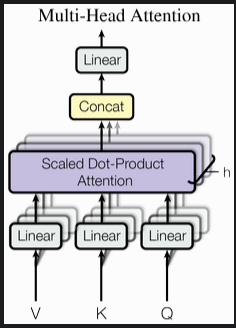

How are we applying a Multi-Head Attention layer in a neural network where we don’t have an arbitrary query, key, and value vector as input? Looking at the computation graph above, a simple but effective implementation is to set the current feature map in a NN,$X \in \mathbb{R}^{B \times T \times d_{model}}$, as $Q$, $K$ and $V$ ($B$ being the batch size, $T$ the sequence length, $d_{model}$ the hidden dimensionality of $X$). The consecutive weight matrices $W^Q$, $W^K$, and $W^V$ can transform $X$ to the corresponding feature vectors that represent the queries, keys, and values of the input. Using this approach, we can implement the Multi-Head Attention module below.

In [13]:
def expand_mask(mask):
    """
    Helper function to support different mask shapes.

    Output shape supports (batch size, number of heads, seq length, seq length)
        If 2D: broadcasted over batch size and number of heads
        If 3D: broadcasted over number of heads
        If 4D: leave as is
    """
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

#### Testing what unsqueeze does

In [74]:
# Create a 3x3 tensor filled with random numbers
test_tensor = torch.randn(3, 3)
print(test_tensor,": test_tensor with dim:",test_tensor.ndim)
print("")
test_tensor_out=test_tensor.unsqueeze(0)
print(test_tensor_out,": unsqueeze(0) with dim:",test_tensor_out.ndim)
print("")
test_tensor_out=test_tensor.unsqueeze(1)
print(test_tensor_out,": unsqueeze(1) with dim:",test_tensor_out.ndim)
print("")
test_tensor_out=expand_mask(test_tensor)
print(test_tensor_out,": expand_mask() with dim:",test_tensor_out.ndim)

tensor([[ 1.8319,  0.7205, -0.1121],
        [-0.0309, -0.1503,  1.8928],
        [ 1.3067, -0.0662, -0.4235]]) : test_tensor with dim: 2

tensor([[[ 1.8319,  0.7205, -0.1121],
         [-0.0309, -0.1503,  1.8928],
         [ 1.3067, -0.0662, -0.4235]]]) : unsqueeze(0) with dim: 3

tensor([[[ 1.8319,  0.7205, -0.1121]],

        [[-0.0309, -0.1503,  1.8928]],

        [[ 1.3067, -0.0662, -0.4235]]]) : unsqueeze(1) with dim: 3

tensor([[[[ 1.8319,  0.7205, -0.1121],
          [-0.0309, -0.1503,  1.8928],
          [ 1.3067, -0.0662, -0.4235]]]]) : expand_mask() with dim: 4


### Define MultiHeadAttention(nn.Module) class

In [ ]:
class MultiheadAttention(nn.Module):
    """
    Allows the model to jointly attend to information from different representation subspaces.
    Method described in the paper: Attention Is All You Need <https://arxiv.org/abs/1706.03762>
    """
    def __init__(self, input_dim, embed_dim, num_heads, dropout_p):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.dropout_p = dropout_p

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        """
        Reset the parameters for all tensors defined in def __init__()
            qkv_proj.weight                         - Filled with random numbers from the xavier_uniform_ distribution
            qkv_proj.bias.data and o_proj.bias.data - Filled with floating point zero values
        """
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(
            self,
            query: torch.Tensor,
            key: torch.Tensor,
            value: torch.Tensor, x, mask=None, return_attention=False):
        """
        Compute attention outputs using query, key, and value embeddings.
        """
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product_attention(q, k, v, mask=mask, dropout_p=self.dropout_p)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

In [ ]:
import warnings
from typing import Optional, Tuple

import torch
from torch import Tensor
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
# from .module import Module
from torch.nn import functional as F

In [ ]:
class MultiheadAttention(nn.Module):

    __constants__ = ['batch_first']
    bias_k: Optional[torch.Tensor]
    bias_v: Optional[torch.Tensor]

    def __init__(self, embed_dim, num_heads, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False,
                 kdim=None, vdim=None, batch_first=False, device=None, dtype=None) -> None:
        if embed_dim <= 0 or num_heads <= 0:
            raise ValueError(
                f"embed_dim and num_heads must be greater than 0,"
                f" got embed_dim={embed_dim} and num_heads={num_heads} instead"
            )
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.batch_first = batch_first
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        if not self._qkv_same_embed_dim:
            self.q_proj_weight = Parameter(torch.empty((embed_dim, embed_dim), **factory_kwargs))
            self.k_proj_weight = Parameter(torch.empty((embed_dim, self.kdim), **factory_kwargs))
            self.v_proj_weight = Parameter(torch.empty((embed_dim, self.vdim), **factory_kwargs))
            self.register_parameter('in_proj_weight', None)
        else:
            self.in_proj_weight = Parameter(torch.empty((3 * embed_dim, embed_dim), **factory_kwargs))
            self.register_parameter('q_proj_weight', None)
            self.register_parameter('k_proj_weight', None)
            self.register_parameter('v_proj_weight', None)

        if bias:
            self.in_proj_bias = Parameter(torch.empty(3 * embed_dim, **factory_kwargs))
        else:
            self.register_parameter('in_proj_bias', None)
        self.out_proj = NonDynamicallyQuantizableLinear(embed_dim, embed_dim, bias=bias, **factory_kwargs)

        if add_bias_kv:
            self.bias_k = Parameter(torch.empty((1, 1, embed_dim), **factory_kwargs))
            self.bias_v = Parameter(torch.empty((1, 1, embed_dim), **factory_kwargs))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn

        self._reset_parameters()

    def _reset_parameters(self):
        if self._qkv_same_embed_dim:
            xavier_uniform_(self.in_proj_weight)
        else:
            xavier_uniform_(self.q_proj_weight)
            xavier_uniform_(self.k_proj_weight)
            xavier_uniform_(self.v_proj_weight)

        if self.in_proj_bias is not None:
            constant_(self.in_proj_bias, 0.)
            constant_(self.out_proj.bias, 0.)
        if self.bias_k is not None:
            xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            xavier_normal_(self.bias_v)

    def __setstate__(self, state):
        # Support loading old MultiheadAttention checkpoints generated by v1.1.0
        if '_qkv_same_embed_dim' not in state:
            state['_qkv_same_embed_dim'] = True

        super().__setstate__(state)

    def forward(
            self,
            query: Tensor,
            key: Tensor,
            value: Tensor,
            key_padding_mask: Optional[Tensor] = None,
            need_weights: bool = True,
            attn_mask: Optional[Tensor] = None,
            average_attn_weights: bool = True,
            is_causal : bool = False) -> Tuple[Tensor, Optional[Tensor]]:
        r"""Compute attention outputs using query, key, and value embeddings.

        Supports optional parameters for padding, masks and attention weights.

    Args:
        query: Query embeddings of shape :math:`(L, E_q)` for unbatched input, :math:`(L, N, E_q)` when ``batch_first=False``
            or :math:`(N, L, E_q)` when ``batch_first=True``, where :math:`L` is the target sequence length,
            :math:`N` is the batch size, and :math:`E_q` is the query embedding dimension ``embed_dim``.
            Queries are compared against key-value pairs to produce the output.
            See "Attention Is All You Need" for more details.
        key: Key embeddings of shape :math:`(S, E_k)` for unbatched input, :math:`(S, N, E_k)` when ``batch_first=False``
            or :math:`(N, S, E_k)` when ``batch_first=True``, where :math:`S` is the source sequence length,
            :math:`N` is the batch size, and :math:`E_k` is the key embedding dimension ``kdim``.
            See "Attention Is All You Need" for more details.
        value: Value embeddings of shape :math:`(S, E_v)` for unbatched input, :math:`(S, N, E_v)` when
            ``batch_first=False`` or :math:`(N, S, E_v)` when ``batch_first=True``, where :math:`S` is the source
            sequence length, :math:`N` is the batch size, and :math:`E_v` is the value embedding dimension ``vdim``.
            See "Attention Is All You Need" for more details.
        key_padding_mask: If specified, a mask of shape :math:`(N, S)` indicating which elements within ``key``
            to ignore for the purpose of attention (i.e. treat as "padding"). For unbatched `query`, shape should be :math:`(S)`.
            Binary and float masks are supported.
            For a binary mask, a ``True`` value indicates that the corresponding ``key`` value will be ignored for
            the purpose of attention. For a float mask, it will be directly added to the corresponding ``key`` value.
        need_weights: If specified, returns ``attn_output_weights`` in addition to ``attn_outputs``.
            Set ``need_weights=False`` to use the optimized ``scaled_dot_product_attention``
            and achieve the best performance for MHA.
            Default: ``True``.
        attn_mask: If specified, a 2D or 3D mask preventing attention to certain positions. Must be of shape
            :math:`(L, S)` or :math:`(N\cdot\text{num\_heads}, L, S)`, where :math:`N` is the batch size,
            :math:`L` is the target sequence length, and :math:`S` is the source sequence length. A 2D mask will be
            broadcasted across the batch while a 3D mask allows for a different mask for each entry in the batch.
            Binary and float masks are supported. For a binary mask, a ``True`` value indicates that the
            corresponding position is not allowed to attend. For a float mask, the mask values will be added to
            the attention weight.
            If both attn_mask and key_padding_mask are supplied, their types should match.
        average_attn_weights: If true, indicates that the returned ``attn_weights`` should be averaged across
            heads. Otherwise, ``attn_weights`` are provided separately per head. Note that this flag only has an
            effect when ``need_weights=True``. Default: ``True`` (i.e. average weights across heads)
        is_causal: If specified, applies a causal mask as attention mask.
            Default: ``False``.
            Warning:
            ``is_causal`` provides a hint that ``attn_mask`` is the
            causal mask. Providing incorrect hints can result in
            incorrect execution, including forward and backward
            compatibility.

    Outputs:
        - **attn_output** - Attention outputs of shape :math:`(L, E)` when input is unbatched,
          :math:`(L, N, E)` when ``batch_first=False`` or :math:`(N, L, E)` when ``batch_first=True``,
          where :math:`L` is the target sequence length, :math:`N` is the batch size, and :math:`E` is the
          embedding dimension ``embed_dim``.
        - **attn_output_weights** - Only returned when ``need_weights=True``. If ``average_attn_weights=True``,
          returns attention weights averaged across heads of shape :math:`(L, S)` when input is unbatched or
          :math:`(N, L, S)`, where :math:`N` is the batch size, :math:`L` is the target sequence length, and
          :math:`S` is the source sequence length. If ``average_attn_weights=False``, returns attention weights per
          head of shape :math:`(\text{num\_heads}, L, S)` when input is unbatched or :math:`(N, \text{num\_heads}, L, S)`.

        .. note::
            `batch_first` argument is ignored for unbatched inputs.
        """
        why_not_fast_path = ''
        if ((attn_mask is not None and torch.is_floating_point(attn_mask))
           or (key_padding_mask is not None) and torch.is_floating_point(key_padding_mask)):
            why_not_fast_path = "floating-point masks are not supported for fast path."

        is_batched = query.dim() == 3

        key_padding_mask = F._canonical_mask(
            mask=key_padding_mask,
            mask_name="key_padding_mask",
            other_type=F._none_or_dtype(attn_mask),
            other_name="attn_mask",
            target_type=query.dtype
        )

        attn_mask = F._canonical_mask(
            mask=attn_mask,
            mask_name="attn_mask",
            other_type=None,
            other_name="",
            target_type=query.dtype,
            check_other=False,
        )

        is_fastpath_enabled = torch.backends.mha.get_fastpath_enabled()

        if not is_fastpath_enabled:
            why_not_fast_path = "torch.backends.mha.get_fastpath_enabled() was not True"
        elif not is_batched:
            why_not_fast_path = f"input not batched; expected query.dim() of 3 but got {query.dim()}"
        elif query is not key or key is not value:
            # When lifting this restriction, don't forget to either
            # enforce that the dtypes all match or test cases where
            # they don't!
            why_not_fast_path = "non-self attention was used (query, key, and value are not the same Tensor)"
        elif self.in_proj_bias is not None and query.dtype != self.in_proj_bias.dtype:
            why_not_fast_path = f"dtypes of query ({query.dtype}) and self.in_proj_bias ({self.in_proj_bias.dtype}) don't match"
        elif self.in_proj_weight is None:
            why_not_fast_path = "in_proj_weight was None"
        elif query.dtype != self.in_proj_weight.dtype:
            # this case will fail anyway, but at least they'll get a useful error message.
            why_not_fast_path = f"dtypes of query ({query.dtype}) and self.in_proj_weight ({self.in_proj_weight.dtype}) don't match"
        elif self.training:
            why_not_fast_path = "training is enabled"
        elif (self.num_heads % 2) != 0:
            why_not_fast_path = "self.num_heads is not even"
        elif not self.batch_first:
            why_not_fast_path = "batch_first was not True"
        elif self.bias_k is not None:
            why_not_fast_path = "self.bias_k was not None"
        elif self.bias_v is not None:
            why_not_fast_path = "self.bias_v was not None"
        elif self.add_zero_attn:
            why_not_fast_path = "add_zero_attn was enabled"
        elif not self._qkv_same_embed_dim:
            why_not_fast_path = "_qkv_same_embed_dim was not True"
        elif query.is_nested and (key_padding_mask is not None or attn_mask is not None):
            why_not_fast_path = "supplying both src_key_padding_mask and src_mask at the same time \
                                 is not supported with NestedTensor input"
        elif torch.is_autocast_enabled():
            why_not_fast_path = "autocast is enabled"

        if not why_not_fast_path:
            tensor_args = (
                query,
                key,
                value,
                self.in_proj_weight,
                self.in_proj_bias,
                self.out_proj.weight,
                self.out_proj.bias,
            )
            # We have to use list comprehensions below because TorchScript does not support
            # generator expressions.
            if torch.overrides.has_torch_function(tensor_args):
                why_not_fast_path = "some Tensor argument has_torch_function"
            elif _is_make_fx_tracing():
                why_not_fast_path = "we are running make_fx tracing"
            elif not all(_check_arg_device(x) for x in tensor_args):
                why_not_fast_path = ("some Tensor argument's device is neither one of "
                                     f"cpu, cuda or {torch.utils.backend_registration._privateuse1_backend_name}")
            elif torch.is_grad_enabled() and any(_arg_requires_grad(x) for x in tensor_args):
                why_not_fast_path = ("grad is enabled and at least one of query or the "
                                     "input/output projection weights or biases requires_grad")
            if not why_not_fast_path:
                merged_mask, mask_type = self.merge_masks(attn_mask, key_padding_mask, query)

                if self.in_proj_bias is not None and self.in_proj_weight is not None:
                    return torch._native_multi_head_attention(
                        query,
                        key,
                        value,
                        self.embed_dim,
                        self.num_heads,
                        self.in_proj_weight,
                        self.in_proj_bias,
                        self.out_proj.weight,
                        self.out_proj.bias,
                        merged_mask,
                        need_weights,
                        average_attn_weights,
                        mask_type)

        any_nested = query.is_nested or key.is_nested or value.is_nested
        assert not any_nested, ("MultiheadAttention does not support NestedTensor outside of its fast path. " +
                                f"The fast path was not hit because {why_not_fast_path}")

        if self.batch_first and is_batched:
            # make sure that the transpose op does not affect the "is" property
            if key is value:
                if query is key:
                    query = key = value = query.transpose(1, 0)
                else:
                    query, key = (x.transpose(1, 0) for x in (query, key))
                    value = key
            else:
                query, key, value = (x.transpose(1, 0) for x in (query, key, value))

        if not self._qkv_same_embed_dim:
            attn_output, attn_output_weights = F.multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask,
                use_separate_proj_weight=True,
                q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
                v_proj_weight=self.v_proj_weight,
                average_attn_weights=average_attn_weights,
                is_causal=is_causal)
        else:
            attn_output, attn_output_weights = F.multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask,
                need_weights=need_weights,
                attn_mask=attn_mask,
                average_attn_weights=average_attn_weights,
                is_causal=is_causal)
        if self.batch_first and is_batched:
            return attn_output.transpose(1, 0), attn_output_weights
        else:
            return attn_output, attn_output_weights


    def merge_masks(self, attn_mask: Optional[Tensor], key_padding_mask: Optional[Tensor],
                    query: Tensor) -> Tuple[Optional[Tensor], Optional[int]]:
        r"""Determine mask type and combine masks if necessary.

        If only one mask is provided, that mask
        and the corresponding mask type will be returned. If both masks are provided, they will be both
        expanded to shape ``(batch_size, num_heads, seq_len, seq_len)``, combined with logical ``or``
        and mask type 2 will be returned
        Args:
            attn_mask: attention mask of shape ``(seq_len, seq_len)``, mask type 0
            key_padding_mask: padding mask of shape ``(batch_size, seq_len)``, mask type 1
            query: query embeddings of shape ``(batch_size, seq_len, embed_dim)``
        Returns:
            merged_mask: merged mask
            mask_type: merged mask type (0, 1, or 2)
        """
        mask_type: Optional[int] = None
        merged_mask: Optional[Tensor] = None

        if key_padding_mask is not None:
            mask_type = 1
            merged_mask = key_padding_mask

        if attn_mask is not None:
            # In this branch query can't be a nested tensor, so it has a shape
            batch_size, seq_len, _ = query.shape
            mask_type = 2

            # Always expands attn_mask to 4D
            if attn_mask.dim() == 3:
                attn_mask_expanded = attn_mask.view(batch_size, -1, seq_len, seq_len)
            else:  # attn_mask.dim() == 2:
                attn_mask_expanded = attn_mask.view(1, 1, seq_len, seq_len).expand(batch_size, self.num_heads, -1, -1)
            merged_mask = attn_mask_expanded

            if key_padding_mask is not None:
                key_padding_mask_expanded = key_padding_mask.view(batch_size, 1, 1, seq_len).expand(-1, self.num_heads, -1, -1)
                merged_mask = attn_mask_expanded + key_padding_mask_expanded

        # no attn_mask and no key_padding_mask, returns None, None
        return merged_mask, mask_type

In [71]:
print("========================================================================")
print("=== Test _reset_parameters                                           ===")
print("========================================================================")
w = torch.empty(3, 5)
print(w,": Initial empty tensor")
print(nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu')), ": xavier_uniform_ random numbers")
print(nn.init.constant_(w, 0.3), ": constant_ of 0.3")
print(nn.init.xavier_normal_(w), ": xavier_normal_ random numbers")

tensor([[-2.8573e+11,  1.1897e-42,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]]) : Initial empty tensor
tensor([[-0.9516, -0.6181,  0.3734,  0.2589, -0.3123],
        [ 0.7300,  0.8326, -0.8882, -0.6539,  1.1215],
        [-0.4133, -0.4342, -1.1851, -0.7014,  0.3059]]) : xavier_uniform_ random numbers
tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000]]) : constant_ of 0.3
tensor([[-0.2185,  0.0388, -0.4614, -0.3645,  0.3638],
        [-0.0036, -0.4889,  0.5020, -0.0124,  0.0736],
        [-0.0651, -0.3776, -0.3182, -0.3423, -0.6429]]) : xavier_normal_ random numbers


In [3]:
print("========================================================================")
print("=== Test linear_layer                                                ===")
print("========================================================================")
## Creating an object for the linear class
linear_layer = nn.Linear(in_features=3, out_features=1)
print(linear_layer)
input_tensor  = torch.tensor([1,2,3], dtype=torch.float32)
output_tensor = linear_layer(input_tensor)
print("")
print("input",input_tensor)
print("output",output_tensor)
print("")
print("Weight",linear_layer.weight)
print("")
print("Bias",linear_layer.bias)

=== Test linear_layer                                                ===
Linear(in_features=3, out_features=1, bias=True)

input tensor([1., 2., 3.])
output tensor([-0.8577], grad_fn=<ViewBackward0>)

Weight Parameter containing:
tensor([[ 0.5069, -0.4725, -0.2099]], requires_grad=True)

Bias Parameter containing:
tensor([0.2100], requires_grad=True)


In [4]:
embed_dim=10



E = q.size(-1)
    if k is v:
        if q is k:
            # self-attention
            proj = linear(q, w, b)
            # reshape to 3, E and not E, 3 is deliberate for better memory coalescing and keeping same order as chunk()
            proj = (
                proj.unflatten(-1, (3, E))
                .unsqueeze(0)
                .transpose(0, -2)
                .squeeze(-2)
                .contiguous()
            )
            return proj[0], proj[1], proj[2]

{'training': True,
 '_parameters': OrderedDict([('weight', Parameter containing:
               tensor([[ 0.5069, -0.4725, -0.2099]], requires_grad=True)),
              ('bias',
               Parameter containing:
               tensor([0.2100], requires_grad=True))]),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'in_features': 3,
 'out_features': 1}

One crucial characteristic of the multi-head attention is that it is permutation-equivariant with respect to its inputs. This means that if we switch two input elements in the sequence, e.g. $X_1\leftrightarrow X_2$ (neglecting the batch dimension for now), the output is exactly the same besides the elements 1 and 2 switched. Hence, the multi-head attention is actually looking at the input not as a sequence, but as a set of elements. This property makes the multi-head attention block and the Transformer architecture so powerful and widely applicable! But what if the order of the input is actually important for solving the task, like language modeling? The answer is to encode the position in the input features, which we will take a closer look at later (topic _Positional encodings_ below).

Before moving on to creating the Transformer architecture, we can compare the self-attention operation with our other common layer competitors for sequence data: convolutions and recurrent neural networks. Below you can find a table by [Vaswani et al. (2017)](https://arxiv.org/abs/1706.03762) on the complexity per layer, the number of sequential operations, and maximum path length. The complexity is measured by the upper bound of the number of operations to perform, while the maximum path length represents the maximum number of steps a forward or backward signal has to traverse to reach any other position. The lower this length, the better gradient signals can backpropagate for long-range dependencies. Let's take a look at the table below:

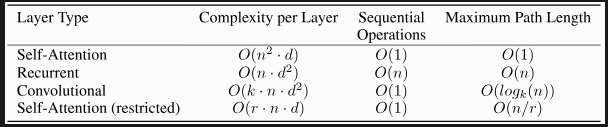

$n$ is the sequence length, $d$ is the representation dimension and $k$ is the kernel size of convolutions. In contrast to recurrent networks, the self-attention layer can parallelize all its operations making it much faster to execute for smaller sequence lengths. However, when the sequence length exceeds the hidden dimensionality, self-attention becomes more expensive than RNNs. One way of reducing the computational cost for long sequences is by restricting the self-attention to a neighborhood of inputs to attend over, denoted by $r$. Nevertheless, there has been recently a lot of work on more efficient Transformer architectures that still allow long dependencies, of which you can find an overview in the paper by [Tay et al. (2020)](https://arxiv.org/abs/2009.06732) if interested.

### Transformer Encoder

Next, we will look at how to apply the multi-head attention block inside the Transformer architecture. Originally, the Transformer model was designed for machine translation. Hence, it got an encoder-decoder structure where the encoder takes as input the sentence in the original language and generates an attention-based representation. On the other hand, the decoder attends over the encoded information and generates the translated sentence in an autoregressive manner, as in a standard RNN. While this structure is extremely useful for Sequence-to-Sequence tasks with the necessity of autoregressive decoding, we will focus here on the encoder part. Many advances in NLP have been made using pure encoder-based Transformer models (if interested, models include the [BERT](https://arxiv.org/abs/1810.04805)-family, the [Vision Transformer](https://arxiv.org/abs/2010.11929), and more), and in our tutorial, we will also mainly focus on the encoder part. If you have understood the encoder architecture, the decoder is a very small step to implement as well. The full Transformer architecture looks as follows (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).:

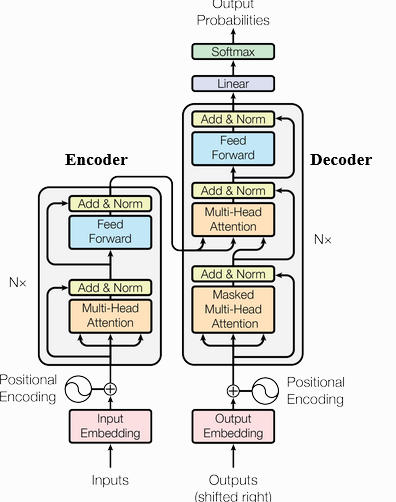

The encoder consists of $N$ identical blocks that are applied in sequence. Taking as input $x$, it is first passed through a Multi-Head Attention block as we have implemented above. The output is added to the original input using a residual connection, and we apply a consecutive Layer Normalization on the sum. Overall, it calculates $\text{LayerNorm}(x+\text{Multihead}(x,x,x))$ ($x$ being $Q$, $K$ and $V$ input to the attention layer). The residual connection is crucial in the Transformer architecture for two reasons: 

1. Similar to ResNets, Transformers are designed to be very deep. Some models contain more than 24 blocks in the encoder. Hence, the residual connections are crucial for enabling a smooth gradient flow through the model.
2. Without the residual connection, the information about the original sequence is lost. Remember that the Multi-Head Attention layer ignores the position of elements in a sequence, and can only learn it based on the input features. Removing the residual connections would mean that this information is lost after the first attention layer (after initialization), and with a randomly initialized query and key vector, the output vectors for position $i$ has no relation to its original input. All outputs of the attention are likely to represent similar/same information, and there is no chance for the model to distinguish which information came from which input element. An alternative option to residual connection would be to fix at least one head to focus on its original input, but this is very inefficient and does not have the benefit of the improved gradient flow.

The Layer Normalization also plays an important role in the Transformer architecture as it enables faster training and provides small regularization. Additionally, it ensures that the features are in a similar magnitude among the elements in the sequence. We are not using Batch Normalization because it depends on the batch size which is often small with Transformers (they require a lot of GPU memory), and BatchNorm has shown to perform particularly bad in language as the features of words tend to have a much higher variance (there are many, very rare words which need to be considered for a good distribution estimate).

Additionally to the Multi-Head Attention, a small fully connected feed-forward network is added to the model, which is applied to each position separately and identically. Specifically, the model uses a Linear $\to$ ReLU $\to$ Linear MLP. The full transformation including the residual connection can be expressed as:  

$$
\begin{split}
    \text{FFN}(x) & = \max(0, xW_1+b_1)W_2 + b_2\\
    x & = \text{LayerNorm}(x + \text{FFN}(x))
\end{split}
$$

This MLP adds extra complexity to the model and allows transformations on each sequence element separately. You can imagine as this allows the model to "post-process" the new information added by the previous Multi-Head Attention, and prepare it for the next attention block. Usually, the inner dimensionality of the MLP is 2-8 $\times$ larger than $d_{\text{model}}$, i.e. the dimensionality of the original input $x$. The general advantage of a wider layer instead of a narrow, multi-layer MLP is the faster, parallelizable execution.

Finally, after looking at all parts of the encoder architecture, we can start implementing it below. We first start by implementing a single encoder block. Additionally to the layers described above, we will add dropout layers in the MLP and on the output of the MLP and Multi-Head Attention for regularization.

In [ ]:
class EncoderBlock(nn.Module):
    """
    An encoder block is is made up of a self-attention block and a feedforward network.
    """

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout_p=0.0):
        """
        Inputs:
            input_dim (int)       - Dimensionality of the input
            num_heads (int)       - Number of heads to use in the attention block
            dim_feedforward (int) - Dimensionality of the hidden layer in the MLP
            dropout_p (float)     - Dropout probability to use in the dropout layers
        """
        super().__init__()
        
        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads, dropout_p)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout_p),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

Based on this block, we can implement a module for the full Transformer encoder. Additionally to a forward function that iterates through the sequence of encoder blocks, we also provide a function called `get_attention_maps`. The idea of this function is to return the attention probabilities for all Multi-Head Attention blocks in the encoder. This helps us in understanding, and in a sense, explaining the model. However, the attention probabilities should be interpreted with a grain of salt as it does not necessarily reflect the true interpretation of the model (there is a series of papers about this, including [Attention is not Explanation](https://arxiv.org/abs/1902.10186) and [Attention is not not Explanation](https://arxiv.org/abs/1908.04626)).

In [88]:
class TransformerEncoder(nn.Module):
    """
    TransformerEncoder is a stack of N encoder layers.
    Users can build the BERT(https://arxiv.org/abs/1810.04805) model with corresponding parameters.
    """

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        """
        Return attention weights that were calculated in the
        multi-head attention block for each layer.
        """
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

### Transformer Decoder

In [ ]:
class DecoderBlock(nn.Module):
    """
    An encoder block is is made up of a self-attention block and a feedforward network.
    """

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout_p=0.0):
        """
        Inputs:
            input_dim (int)       - Dimensionality of the input
            num_heads (int)       - Number of heads to use in the attention block
            dim_feedforward (int) - Dimensionality of the hidden layer in the MLP
            dropout_p (float)     - Dropout probability to use in the dropout layers
        """
        super().__init__()
        
        # Attention layers
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads, dropout_p)
        self.cross_attn = MultiheadAttention(input_dim, input_dim, num_heads, dropout_p)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout_p),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.norm3 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x, encoder_output, source_mask=None, target_mask=None):
        # Self Attention part
        attn_out = self.self_attn(x, mask=target_mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # Cross Attention part
        attn_out = self.cross_attn(x, mask=source_mask)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

### Positional encoding

We have discussed before that the Multi-Head Attention block is permutation-equivariant, and cannot distinguish whether an input comes before another one in the sequence or not. In tasks like language understanding, however, the position is important for interpreting the input words. The position information can therefore be added via the input features. We could learn a embedding for every possible position, but this would not generalize to a dynamical input sequence length. Hence, the better option is to use feature patterns that the network can identify from the features and potentially generalize to larger sequences. The specific pattern chosen by Vaswani et al. are sine and cosine functions of different frequencies, as follows:

$$
PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}
$$

$PE_{(pos,i)}$ represents the position encoding at position $pos$ in the sequence, and hidden dimensionality $i$. These values, concatenated for all hidden dimensions, are added to the original input features (in the Transformer visualization above, see "Positional encoding"), and constitute the position information. We distinguish between even ($i \text{ mod } 2=0$) and uneven ($i \text{ mod } 2=1$) hidden dimensionalities where we apply a sine/cosine respectively. The intuition behind this encoding is that you can represent $PE_{(pos+k,:)}$ as a linear function of $PE_{(pos,:)}$, which might allow the model to easily attend to relative positions. The wavelengths in different dimensions range from $2\pi$ to $10000\cdot 2\pi$.

The positional encoding is implemented below. The code is taken from the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html#define-the-model) about Transformers on NLP and adjusted for our purposes.

In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model (int) - Hidden dimensionality of the input.
            max_len (int) - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model) 
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [104]:
print('======================================================')
print('=== Test parts of PositionalEncoding() ====')
print('======================================================')
max_len=10
d_model=4
pe = torch.zeros(max_len, d_model)
print('max_len=',max_len)
print('d_model=',d_model)
print('pe:')
print(pe)

print('')
print(f'position: Create 1D Tensor of len: {max_len}, then apply unsqueeze(1)')
position=torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
print(position)

print('')
print(f'div_term: Create 1D tensor to divide position value by')
print(f'   -math.log(10000.0)                           = {-math.log(10000.0)}')
print(f'  (-math.log(10000.0) / d_model)                = {(-math.log(10000.0) / d_model)}')
print(f'  torch.arange(0, d_model, 2)                   = {torch.arange(0, d_model, 2)}')
print(f'  torch.arange(0, d_model, 2).float()           = {torch.arange(0, d_model, 2).float()}')
print(f'  torch.arange(0, d_model, 2).float()  ')
print(f'  * (-math.log(10000.0) / d_model)              = {torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)}')

div_term=torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
print(f'  torch.exp(torch.arange(0, d_model, 2).float()')
print(f'  * (-math.log(10000.0) / d_model))             = {div_term}')

print('')
print('position * div_term:')
print(position * div_term)

print('')
print(' torch.sin(position * div_term):')
print(torch.sin(position * div_term))


print('')
print(' pe[:, 0::2] = torch.sin(position * div_term):')
pe[:, 0::2] = torch.sin(position * div_term)
print(pe)

print('')
print(' pe[:, 1::2] = torch.cos(position * div_term):')
pe[:, 1::2] = torch.cos(position * div_term)
print(pe)

print('')
pe = pe.unsqueeze(0)
print(' pe.unsqueeze(0):')
print(pe)

print('')
pe = pe.unsqueeze(0)
print(' pe.unsqueeze(0):')
print(pe)


x=torch.ones(2,3)
pe[:, :x.size(1)]


=== Test parts of PositionalEncoding() ====
max_len= 10
d_model= 4
pe:
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

position: Create 1D Tensor of len: 10, then apply unsqueeze(1)
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

div_term: Create 1D tensor to divide position value by
   -math.log(10000.0)                           = -9.210340371976184
  (-math.log(10000.0) / d_model)                = -2.302585092994046
  torch.arange(0, d_model, 2)                   = tensor([0, 2])
  torch.arange(0, d_model, 2).float()           = tensor([0., 2.])
  torch.arange(0, d_model, 2).float()  
  * (-math.log(10000.0) / d_model)              = tensor([-0.0000, -4.6052])
  torch.exp(torch.ar

To understand the positional encoding, we can visualize it below. We will generate an image of the positional encoding over hidden dimensionality and position in a sequence. Each pixel, therefore, represents the change of the input feature we perform to encode the specific position. Let's do it below.

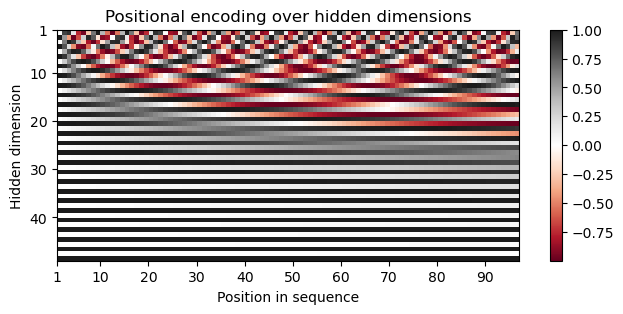

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

You can clearly see the sine and cosine waves with different wavelengths that encode the position in the hidden dimensions. Specifically, we can look at the sine/cosine wave for each hidden dimension separately, to get a better intuition of the pattern. Below we visualize the positional encoding for the hidden dimensions $1$, $2$, $3$ and $4$.

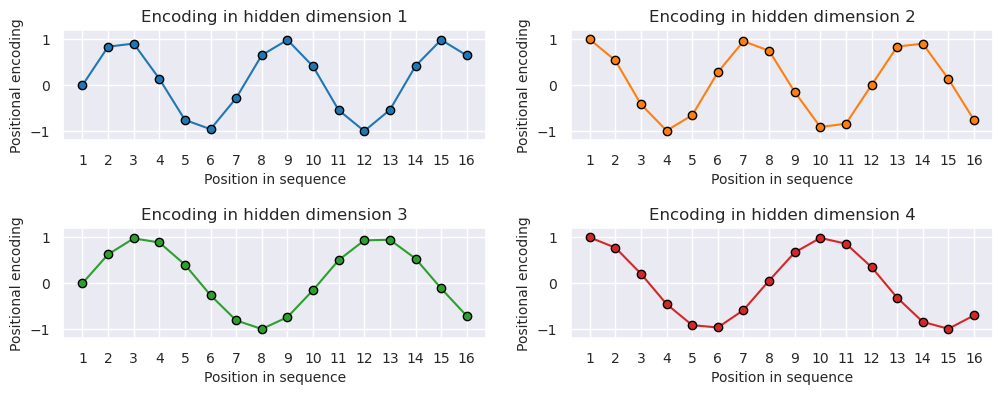

In [116]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

As we can see, the patterns between the hidden dimension $1$ and $2$ only differ in the starting angle. The wavelength is $2\pi$, hence the repetition after position $6$. The hidden dimensions $2$ and $3$ have about twice the wavelength. 

### Learning rate warm-up

One commonly used technique for training a Transformer is learning rate warm-up. This means that we gradually increase the learning rate from 0 on to our originally specified learning rate in the first few iterations. Thus, we slowly start learning instead of taking very large steps from the beginning. In fact, training a deep Transformer without learning rate warm-up can make the model diverge and achieve a much worse performance on training and testing. Take for instance the following plot by [Liu et al. (2019)](https://arxiv.org/pdf/1908.03265.pdf) comparing Adam-vanilla (i.e. Adam without warm-up) vs Adam with a warm-up:

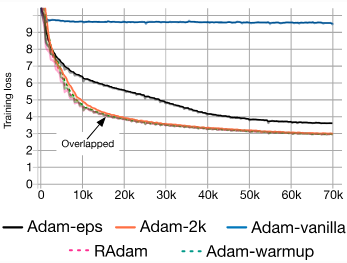

Clearly, the warm-up is a crucial hyperparameter in the Transformer architecture. Why is it so important? There are currently two common explanations. Firstly, Adam uses the bias correction factors which however can lead to a higher variance in the adaptive learning rate during the first iterations. Improved optimizers like [RAdam](https://arxiv.org/abs/1908.03265) have been shown to overcome this issue, not requiring warm-up for training Transformers. Secondly, the iteratively applied Layer Normalization across layers can lead to very high gradients during the first iterations, which can be solved by using [Pre-Layer Normalization](https://proceedings.icml.cc/static/paper_files/icml/2020/328-Paper.pdf) (similar to Pre-Activation ResNet), or replacing Layer Normalization by other techniques ([Adaptive Normalization](https://proceedings.icml.cc/static/paper_files/icml/2020/328-Paper.pdf), [Power Normalization](https://arxiv.org/abs/2003.07845)). 

Nevertheless, many applications and papers still use the original Transformer architecture with Adam, because warm-up is a simple, yet effective way of solving the gradient problem in the first iterations. There are many different schedulers we could use. For instance, the original Transformer paper used an exponential decay scheduler with a warm-up. However, the currently most popular scheduler is the cosine warm-up scheduler, which combines warm-up with a cosine-shaped learning rate decay. We can implement it below, and visualize the learning rate factor over epochs. 

In [117]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)
        
    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]
    
    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

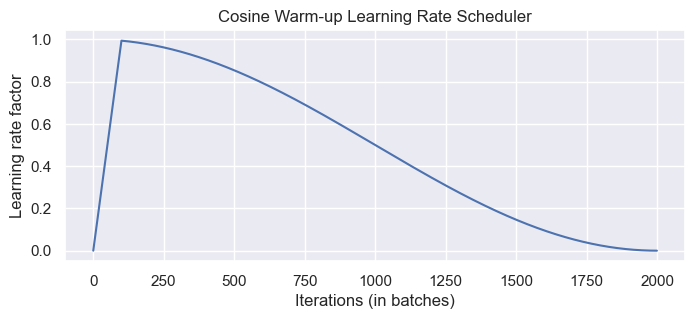

In [118]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In the first 100 iterations, we increase the learning rate factor from 0 to 1, whereas for all later iterations, we decay it using the cosine wave. Pre-implementations of this scheduler can be found in the popular NLP Transformer library [huggingface](https://huggingface.co/transformers/main_classes/optimizer_schedules.html?highlight=cosine#transformers.get_cosine_schedule_with_warmup).

# Position-wise Feed-Forward Networks
The PositionWiseFeedForward class extends PyTorch’s nn.Module and implements a position-wise feed-forward network. The class initializes with two linear transformation layers and a ReLU activation function. The forward method applies these transformations and activation function sequentially to compute the output. This process enables the model to consider the position of input elements while making predictions.

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, embed_dim, ff_dim):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, embed_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Positional Encoding
Positional Encoding is used to inject the position information of each token in the input sequence. It uses sine and cosine functions of different frequencies to generate the positional encoding.

The PositionalEncoding class initializes with input parameters d_model and max_seq_length, creating a tensor to store positional encoding values. The class calculates sine and cosine values for even and odd indices, respectively, based on the scaling factor div_term. The forward method computes the positional encoding by adding the stored positional encoding values to the input tensor, allowing the model to capture the position information of the input sequence.

In [ ]:
class  PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_seq_length):
        """
        Inputs
            embed_dim - Hidden dimensionality of the input.
            max_seq_length - Maximum length of a sequence to expect.
        """

        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, embed_dim)
        position = torch.arrange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arrange(0, embed_dim, 2)).float() * -(math.log(10000.0) / embed_dim)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe

# Encoder Block
An Encoder layer consists of a Multi-Head Attention layer, a Position-wise Feed-Forward layer, and two Layer Normalization layers.

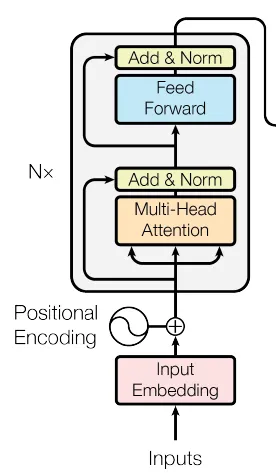

Figure 3. The Encoder part of the transformer network (Source: image from the original paper)

The EncoderLayer class initializes with input parameters and components, including a MultiHeadAttention module, a PositionWiseFeedForward module, two layer normalization modules, and a dropout layer. The forward methods computes the encoder layer output by applying self-attention, adding the attention output to the input tensor, and normalizing the result. Then, it computes the position-wise feed-forward output, combines it with the normalized self-attention output, and normalizes the final result before returning the processed tensor.

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, model_dim, num_heads, ff_dim, dropout=0.0):
        """
        Inputs:
            model_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            ff_dim - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super(EncoderBlock, self).__init__()
        self.self_attn = MultiheadAttention(model_dim, num_heads)
        self.feed_forward = PositionWiseFeedForward(model_dim, ff_dim)
        self.norm1 = nn.LayerNorm(model_dim)
        self.norm2 = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# Decoder Block
A Decoder layer consists of two Multi-Head Attention layers, a Position-wise Feed-Forward layer, and three Layer Normalization layers.

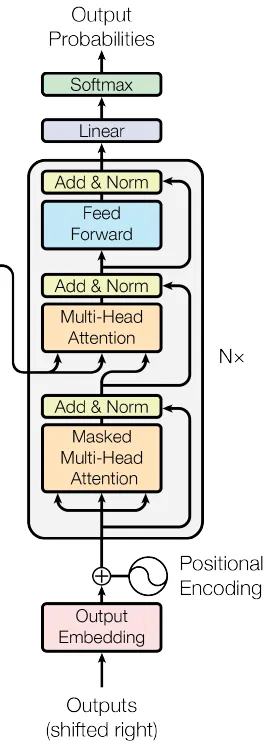

Figure 4. The Decoder part of the Transformer network (Souce: Image from the original paper)

The DecoderLayer initializes with input parameters and components such as MultiHeadAttention modules for masked self-attention and cross-attention, a PositionWiseFeedForward module, three layer normalization modules, and a dropout layer.

The forward method computes the decoder layer output by performing the following steps:

1) Calculate the masked self-attention output and add it to the input tensor, followed by dropout and layer normalization.
2) Compute the cross-attention output between the decoder and encoder outputs, and add it to the normalized masked self-attention output, followed by dropout and layer normalization.
3) Calculate the position-wise feed-forward output and combine it with the normalized cross-attention output, followed by dropout and layer normalization.
4) Return the processed tensor.

These operations enable the decoder to generate target sequences based on the input and the encoder output.

Now, let’s combine the Encoder and Decoder layers to create the complete Transformer model.

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, model_dim, num_heads, ff_dim, dropout=0.0):
        super(DecoderBlock, self).__init__()
        self.self_attn = MultiheadAttention(model_dim, num_heads)
        self.cross_attn = MultiheadAttention(model_dim, num_heads)
        self.feed_forward = PositionWiseFeedForward(model_dim, ff_dim)
        self.norm1 = nn.LayerNorm(model_dim)
        self.norm2 = nn.LayerNorm(model_dim)
        self.norm3 = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output, source_mask, target_mask):
        attn_output = self.self_attn(x, x, x, target_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, encoder_output, source_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

# Transformer Model
The Transformer class combines the previously defined modules to create a complete Transformer model. During initialization, the Transformer module sets up input parameters and initializes various components, including embedding layers for source and target sequences, a PositionalEncoding module, EncoderLayer and DecoderLayer modules to create stacked layers, a linear layer for projecting decoder output, and a dropout layer.

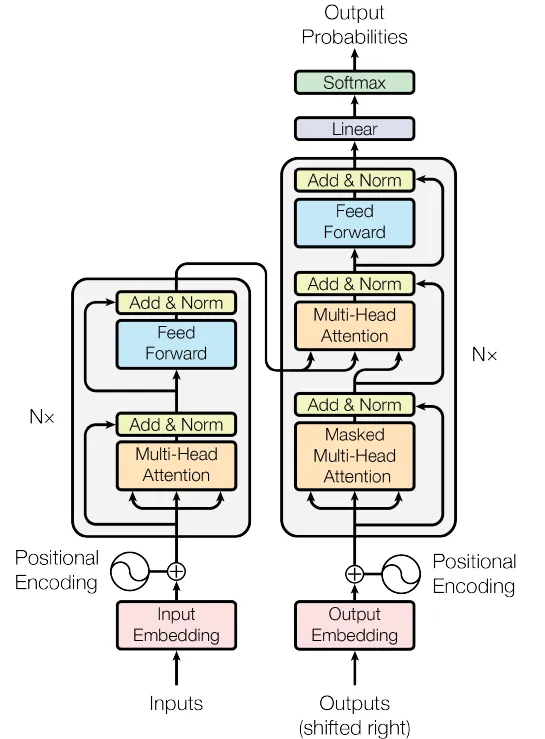

    Figure 5. The Transformer Network (Source: Image from the original paper)

The generate_mask method creates binary masks for source and target sequences to ignore padding tokens and prevent the decoder from attending to future tokens. The forward method computes the Transformer model’s output through the following steps:

1) Generate source and target masks using the generate_mask method.
2) Compute source and target embeddings, and apply positional encoding and dropout.
3) Process the source sequence through encoder layers, updating the enc_output tensor.
4) Process the target sequence through decoder layers, using enc_output and masks, and updating the dec_output tensor.
5) Apply the linear projection layer to the decoder output, obtaining output logits.

These steps enable the Transformer model to process input sequences and generate output sequences based on the combined functionality of its components.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, model_dim, num_heads, num_layers, ff_dim, max_seq_length, dropout=0.0):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, model_dim)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, model_dim)
        self.positional_encoding = PositionalEncoding(model_dim, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderBlock(model_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderBlock(model_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(model_dim, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (src != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask
    
    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)

        src_embeded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))        
        tgt_embeded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        
        enc_output = src_embeded
        for enc_layer  in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embeded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

Preparing Sample Data

In this example, we will create a toy dataset for demonstration purposes. In practice, you would use a larger dataset, preprocess the text, and create vocabulary mappings for source and target languages.